# **Model Klasifikasi Keutuhan Sayur (Utuh/Tidak Utuh)**

### **Import Library**

In [27]:
import subprocess
import sys

packages = ['tensorflow', 'scikit-image', 'tqdm', 'pandas', 'opencv-python', 'seaborn', 'pillow', 'joblib']
for package in packages:
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])

print("All packages installed successfully")


All packages installed successfully


In [28]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import time
import joblib
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.utils import shuffle
from skimage.color import rgb2hsv, hsv2rgb
from skimage import exposure

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.get_logger().setLevel('ERROR')

# set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Imports OK - TensorFlow:", tf.__version__)

Imports OK - TensorFlow: 2.20.0


### **Load Dataset (Utuh/Tidak Utuh)**

In [29]:
DATASET_TRAIN = r"D:\KULIAH 5\PBL\dataset\train"
DATASET_TEST = r"D:\KULIAH 5\PBL\dataset\test"

print("DATASET_TRAIN:", DATASET_TRAIN)

# eksplorasi dataset
categories = ['utuh', 'tidak_utuh']
for cat in categories:
    path = os.path.join(DATASET_TRAIN, cat)
    count = len([f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
    print(f"{cat}: {count} images")

print("\nDATASET_TEST:", DATASET_TEST)

categories = ['utuh', 'tidak_utuh']
for cat in categories:
    path = os.path.join(DATASET_TEST, cat)
    count = len([f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
    print(f"{cat}: {count} images")

DATASET_TRAIN: D:\KULIAH 5\PBL\dataset\train
utuh: 600 images
tidak_utuh: 600 images

DATASET_TEST: D:\KULIAH 5\PBL\dataset\test
utuh: 120 images
tidak_utuh: 120 images


### **Pre-processing Citra**
Resize, BGR→RGB, normalisasi, brightness, histogram, saturation
- Resize ke 224 × 224 piksel
- BGR → RGB
- Normalisasi awal (0–1)
- Brightness & Contrast Adjustment
- Histogram Equalization pada kanal V (HSV)
- Saturation Enhancement

In [30]:
def preprocess_image(image):
    # 1. Resize ke 224 × 224 piksel
    image = cv2.resize(image, (224, 224))

    # 2. BGR → RGB conversion
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 3. Normalisasi awal 0-1
    img = image.astype(np.float32) / 255.0

    # 4. Brightness & Contrast Adjustment
    img_tf = tf.constant(img)

    # Adjust brightness
    brightness_delta = 0.1
    img_tf = tf.image.adjust_brightness(img_tf, brightness_delta)

    # Adjust contrast
    contrast_factor = 1.3
    img_tf = tf.image.adjust_contrast(img_tf, contrast_factor)

    img = img_tf.numpy()
    img = np.clip(img, 0, 1)

    # 5. Histogram Equalization pada Kanal V (HSV)
    img_hsv = rgb2hsv(img)
    v_channel = img_hsv[:, :, 2]
    v_channel_eq = exposure.equalize_adapthist(v_channel)
    img_hsv[:, :, 2] = v_channel_eq
    img = hsv2rgb(img_hsv)

    # 6. Saturation Enhancement
    img_hsv_final = rgb2hsv(img)
    saturation_boost = 1.2
    img_hsv_final[:, :, 1] = np.clip(img_hsv_final[:, :, 1] * saturation_boost, 0, 1)
    img = hsv2rgb(img_hsv_final)

    return np.clip(img, 0, 1).astype(np.float32)

In [31]:
# load dan preprocess semua data training
train_images = []
train_labels = []

print("Loading and preprocessing training data...")
for cat_idx, cat in enumerate(categories):
    cat_path = os.path.join(DATASET_TRAIN, cat)
    files = [f for f in os.listdir(cat_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    
    for file in tqdm(files, desc=f"Processing {cat}"):
        try:
            img_path = os.path.join(cat_path, file)
            img = cv2.imread(img_path)

            img_processed = preprocess_image(img)
            
            train_images.append(img_processed)
            train_labels.append(cat_idx)
        except Exception as e:
            print(f"Error loading {file}: {e}")

# load dan preprocess test data
test_images = []
test_labels = []

print("\nLoading and preprocessing test data...")
for cat_idx, cat in enumerate(categories):
    cat_path = os.path.join(DATASET_TEST, cat)
    files = [f for f in os.listdir(cat_path) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
    
    for file in tqdm(files, desc=f"Processing {cat}"):
        try:
            img_path = os.path.join(cat_path, file)
            img = cv2.imread(img_path)
            
            img_processed = preprocess_image(img)
            
            test_images.append(img_processed)
            test_labels.append(cat_idx)
        except Exception as e:
            print(f"Error loading {file}: {e}")

# Convert to numpy arrays
X_train = np.array(train_images, dtype=np.float32)
y_train = np.array(train_labels, dtype=np.int32)

X_test = np.array(test_images, dtype=np.float32)
y_test = np.array(test_labels, dtype=np.int32)

# Shuffle data
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

print(f"\nTraining data shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"Test data shape: {X_test.shape}, Labels: {y_test.shape}")
print(f"Class distribution - Train: {np.bincount(y_train)}, Test: {np.bincount(y_test)}")

Loading and preprocessing training data...


Processing tidak_utuh: 100%|██████████| 600/600 [00:32<00:00, 18.62it/s]



Loading and preprocessing test data...


Processing tidak_utuh: 100%|██████████| 120/120 [00:06<00:00, 18.37it/s]



Training data shape: (1200, 224, 224, 3), Labels: (1200,)
Test data shape: (240, 224, 224, 3), Labels: (240,)
Class distribution - Train: [600 600], Test: [120 120]


### **Feature Extraction dengan MobileNetV2**
Ekstraksi fitur otomatis dari jaringan MobileNetV2 pretrained (ImageNet):
- Layer awal: menangkap edge & tekstur
- Layer tengah: menangkap warna & pola permukaan
- Layer akhir: menangkap bentuk & kerusakan fisik

### **Classification/Model dengan Dense Layers & Softmax**
- Backbone: MobileNetV2 (frozen)
- Feature Reduction Block: Dense layers dengan ReLU activation
- Dropout layers: Mencegah overfitting
- Batch Normalization: Mempercepat konvergensi
- Output layer: Softmax (2 kelas: Utuh / Tidak Utuh)

**Loss Function**: sparse_categorical_crossentropy

**Optimizer**: Adam dengan learning rate adaptif

In [32]:
def build_model_with_feature_extraction():
    mobilenet_backbone = keras.applications.MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg'
    )
    
    # freeze backbone untuk transfer learning
    mobilenet_backbone.trainable = False
    
    # build model dengan regularization yang lebih kuat
    model = keras.Sequential([
        keras.Input(shape=(224, 224, 3)),
        
        # MobileNetV2 Backbone (Feature Extraction dari Low→Mid→High)
        mobilenet_backbone,
        
        # SIMPLIFIED Dense Block dengan HIGHER Dropout & L2 Regularization
        layers.Dense(256, activation='relu', 
                    kernel_regularizer=keras.regularizers.l2(0.001),
                    name='dense_256'),
        layers.BatchNormalization(name='bn_256'),
        layers.Dropout(0.6, name='dropout_0.6'),
        
        layers.Dense(128, activation='relu',
                    kernel_regularizer=keras.regularizers.l2(0.001),
                    name='dense_128'),
        layers.BatchNormalization(name='bn_128'),
        layers.Dropout(0.5, name='dropout_0.5'),
        
        # Direct to output (simplified, no 64-dim layer)
        layers.Dense(2, activation='softmax', name='output')  # 2 classes
    ])
    
    return model, mobilenet_backbone

# Build model
print("Building model with MobileNetV2 feature extraction...")
model, backbone = build_model_with_feature_extraction()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Building model with MobileNetV2 feature extraction...


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_256 (BatchNormalization)     │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_0.6 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_128 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_128 (BatchNormalization)     │ (None, 128)            │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_0.5 (Dropout)           │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,620,610 (10.00 MB)

 Trainable params: 361,858 (1.38 MB)

 Non-trainable params: 2,258,752 (8.62 MB)

### **Model Training**
Training dengan strategi optimasi:
- Epochs: 30 (atau sampai early stopping)
- Batch size: 32 samples per batch
- Validation split: 20% dari training data
- Early Stopping: Monitor val_loss dengan patience=5
- ReduceLROnPlateau: Turunkan learning rate jika val_loss plateau

In [33]:
# define callbacks
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# train model
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 30s 767ms/step - accuracy: 0.5312 - loss: 1.8362 - val_accuracy: 0.8167 - val_loss: 1.0655 - learning_rate: 1.0000e-04
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 667ms/step - accuracy: 0.7188 - loss: 1.2623 - val_accuracy: 0.9333 - val_loss: 0.8639 - learning_rate: 1.0000e-04
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 666ms/step - accuracy: 0.7979 - loss: 1.1139 - val_accuracy: 0.9417 - val_loss: 0.7850 - learning_rate: 1.0000e-04
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 671ms/step - accuracy: 0.8302 - loss: 1.0101 - val_accuracy: 0.9500 - val_loss: 0.7349 - learning_rate: 1.0000e-04
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 670ms/step - accuracy: 0.8854 - loss: 0.9102 - val_accuracy: 0.9542 - val_loss: 0.7049 - learning_rate: 1.0000e-04
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 681ms/step - accuracy: 0.8813 - loss: 0.8745 - val_accuracy: 0.9625 - val_loss: 0.6866 - learning_rate: 1.0000e-04
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 666ms/step - acc

### **Model Evaluation & Metrics**
Evaluasi pada test set (data belum pernah dilatih):
- **Test Loss & Test Accuracy**
- **Precision** - Dari prediksi positif, berapa yang benar?
- **Recall** - Dari yang seharusnya positif, berapa yang terdeteksi?
- **F1-Score** - Harmonic mean dari precision dan recall
- **Classification Report** - Per-class breakdown
- **Confusion Matrix** - True Positives, False Positives, False Negatives, True Negatives

In [34]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print("\n" + "="*60)
print("TEST SET PERFORMANCE")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Get predictions
y_pred = model.predict(X_test, verbose=0)
y_pred_labels = np.argmax(y_pred, axis=1)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_labels)
precision = precision_score(y_test, y_pred_labels, average='weighted')
recall = recall_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')

print("\nDetailed Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("="*60)

# classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_labels, target_names=categories))


TEST SET PERFORMANCE
Test Loss: 0.9241
Test Accuracy: 0.8625 (86.25%)

Detailed Metrics:
Accuracy:  0.8625
Precision: 0.8718
Recall:    0.8625
F1-Score:  0.8616

Classification Report:
              precision    recall  f1-score   support

        utuh       0.81      0.94      0.87       120
  tidak_utuh       0.93      0.78      0.85       120

    accuracy                           0.86       240
   macro avg       0.87      0.86      0.86       240
weighted avg       0.87      0.86      0.86       240



### **Training History Visualization**
Visualisasi kurva training accuracy & loss per epoch:
- **Accuracy curve**: Train vs Validation
- **Loss curve**: Train vs Validation
- **Deteksi overfitting**: Gap antara train dan validation
- **Best epoch**: Epoch dengan validation loss terendah

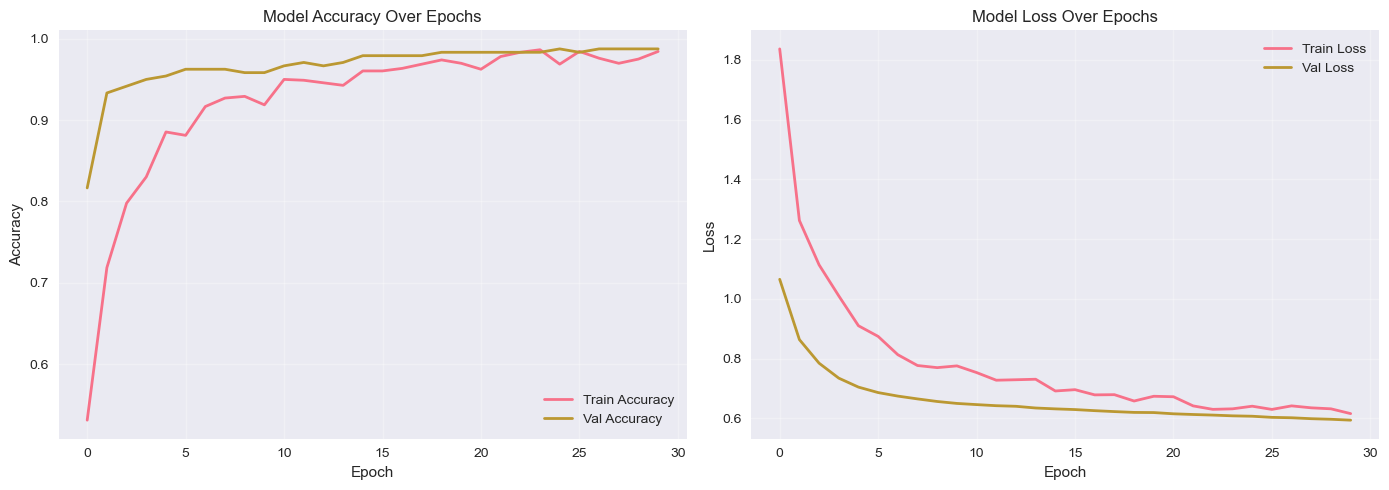

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Model Accuracy Over Epochs')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Model Loss Over Epochs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
# plt.savefig('PBL/training_history.png', dpi=150, bbox_inches='tight')
plt.show()

### **Confusion Matrix & Classification Analysis**
Analisis performa per class dengan confusion matrix heatmap:
- **True Positives (TP)**: Correctly identified utuh/tidak_utuh
- **False Positives (FP)**: Incorrectly labeled as utuh/tidak_utuh
- **False Negatives (FN)**: Missed detections
- **True Negatives (TN)**: Correctly rejected

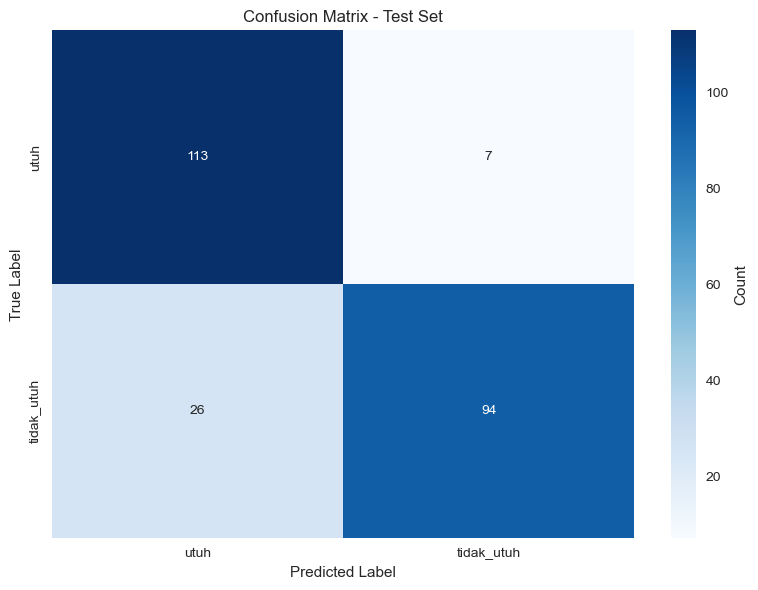

In [36]:
cm = confusion_matrix(y_test, y_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=categories, yticklabels=categories, 
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
# plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()

### **Deep Diagnostics - Model Analysis**
Analisis mendalam untuk diagnosa:
- **Overfitting analysis**: Train vs validation performance gap
- **Data distribution**: Class balance di training dan test
- **Per-class accuracy**: Detil akurasi per kategori
- **Confidence scores**: Distribution prediksi confidence
- **Epoch-by-epoch breakdown**: Key metrics per epoch

In [37]:
print("\n" + "="*70)
print("DATA DISTRIBUTION & PREDICTION ANALYSIS")
print("="*70)

# 1. Class distribution
print("\n1. CLASS DISTRIBUTION:")
train_utuh = np.sum(y_train == 0)
train_tidak = np.sum(y_train == 1)
test_utuh = np.sum(y_test == 0)
test_tidak = np.sum(y_test == 1)

print(f"   Training: Utuh={train_utuh}, Tidak Utuh={train_tidak} (balanced: {train_utuh == train_tidak})")
print(f"   Test:     Utuh={test_utuh}, Tidak Utuh={test_tidak} (balanced: {test_utuh == test_tidak})")

# 2. Get all predictions on test set
y_pred_all = model.predict(X_test, verbose=0)
y_pred_labels = np.argmax(y_pred_all, axis=1)
confidences = np.max(y_pred_all, axis=1)

print("\n2. PREDICTION STATISTICS (Full Test Set):")
print(f"   Total test samples: {len(y_test)}")
print(f"   Predicted as Utuh: {np.sum(y_pred_labels == 0)}")
print(f"   Predicted as Tidak Utuh: {np.sum(y_pred_labels == 1)}")

# 3. Per-class accuracy
utuh_mask = y_test == 0
tidak_utuh_mask = y_test == 1

utuh_correct = np.sum((y_pred_labels == 0) & utuh_mask)
tidak_utuh_correct = np.sum((y_pred_labels == 1) & tidak_utuh_mask)

utuh_acc = utuh_correct / np.sum(utuh_mask) if np.sum(utuh_mask) > 0 else 0
tidak_utuh_acc = tidak_utuh_correct / np.sum(tidak_utuh_mask) if np.sum(tidak_utuh_mask) > 0 else 0

print("\n3. PER-CLASS ACCURACY:")
print(f"   Utuh: {utuh_correct}/{np.sum(utuh_mask)} correct = {utuh_acc:.4f} ({utuh_acc*100:.2f}%)")
print(f"   Tidak Utuh: {tidak_utuh_correct}/{np.sum(tidak_utuh_mask)} correct = {tidak_utuh_acc:.4f} ({tidak_utuh_acc*100:.2f}%)")

# 4. Confidence analysis
print("\n4. CONFIDENCE SCORE ANALYSIS:")
print(f"   Mean confidence: {np.mean(confidences):.4f}")
print(f"   Median confidence: {np.median(confidences):.4f}")
print(f"   Min confidence: {np.min(confidences):.4f}")
print(f"   Max confidence: {np.max(confidences):.4f}")
print(f"   Std deviation: {np.std(confidences):.4f}")

# 5. Confusion matrix details
print("\n5. CONFUSION MATRIX ANALYSIS:")
cm = confusion_matrix(y_test, y_pred_labels)
print(f"   Utuh → Utuh: {cm[0,0]} (correct)")
print(f"   Utuh → Tidak Utuh: {cm[0,1]} (false positive)")
print(f"   Tidak Utuh → Utuh: {cm[1,0]} (false negative)")
print(f"   Tidak Utuh → Tidak Utuh: {cm[1,1]} (correct)")


DATA DISTRIBUTION & PREDICTION ANALYSIS

1. CLASS DISTRIBUTION:
   Training: Utuh=600, Tidak Utuh=600 (balanced: True)
   Test:     Utuh=120, Tidak Utuh=120 (balanced: True)

2. PREDICTION STATISTICS (Full Test Set):
   Total test samples: 240
   Predicted as Utuh: 139
   Predicted as Tidak Utuh: 101

3. PER-CLASS ACCURACY:
   Utuh: 113/120 correct = 0.9417 (94.17%)
   Tidak Utuh: 94/120 correct = 0.7833 (78.33%)

4. CONFIDENCE SCORE ANALYSIS:
   Mean confidence: 0.9287
   Median confidence: 0.9912
   Min confidence: 0.5096
   Max confidence: 1.0000
   Std deviation: 0.1206

5. CONFUSION MATRIX ANALYSIS:
   Utuh → Utuh: 113 (correct)
   Utuh → Tidak Utuh: 7 (false positive)
   Tidak Utuh → Utuh: 26 (false negative)
   Tidak Utuh → Tidak Utuh: 94 (correct)


### **Model Export & Deployment**
Simpan model dan persiapkan untuk deployment:
- **Simpan model** → Keras format (.keras)
- **Konversi ke TFLite** → (.tflite) untuk mobile/edge
- **Flutter integration** → Package tflite_flutter
- **Input/Output specifications** → Model signature

**Output Folder**: `models/`
- `model_mobilenetv2_classifier.keras` - Keras model (full size)
- `model_mobilenetv2_classifier.tflite` - Optimized untuk mobile

In [38]:
os.makedirs('PBL/models', exist_ok=True)

# Save Keras Model
print("="*80)
print("MODEL EXPORT & DEPLOYMENT")
print("="*80)
model.save('PBL/models/model_mobilenetv2_classifier.keras')
print("✓ Keras model saved as: PBL/models/model_mobilenetv2_classifier.keras")

# Convert to TensorFlow Lite (TFLite)
print("\nCONVERTING TO TENSORFLOW LITE (.tflite)")
print("-"*80)

# Create converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [
   tf.lite.OpsSet.TFLITE_BUILTINS,
   tf.lite.OpsSet.SELECT_TF_OPS
]

# Convert model
tflite_model = converter.convert()

# Save TFLite model
with open('PBL/models/model_mobilenetv2_classifier.tflite', 'wb') as f:
   f.write(tflite_model)
print("✓ TFLite model saved as: PBL/models/model_mobilenetv2_classifier.tflite")

# Model Information
print("\nMODEL INFORMATION")
print("-"*80)

# Keras model size
keras_size = os.path.getsize('PBL/models/model_mobilenetv2_classifier.keras') / (1024 * 1024)
tflite_size = os.path.getsize('PBL/#models/model_mobilenetv2_classifier.tflite') / (1024 * 1024)

print(f"Keras model size: {keras_size:.2f} MB")
print(f"TFLite model size: {tflite_size:.2f} MB")
print(f"Compression ratio: {(1 - tflite_size/keras_size)*100:.1f}%")

MODEL EXPORT & DEPLOYMENT
✓ Keras model saved as: PBL/models/model_mobilenetv2_classifier.keras

CONVERTING TO TENSORFLOW LITE (.tflite)
--------------------------------------------------------------------------------
Saved artifact at 'C:\Users\p\AppData\Local\Temp\tmpgw72ximx'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_483')
Output Type:
  TensorSpec(shape=(None, 2), dtype=tf.float32, name=None)
Captures:
  2511631333136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2511631332944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2511631334672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2511631334864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2511631333328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2511631333712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2511631335056: TensorSpec(shape=(), dtype=tf.resource, name

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'PBL/#models/model_mobilenetv2_classifier.tflite'